# For all runs

In [1]:
import pandas as pd
import wandb
import numpy as np

api = wandb.Api()

runs = api.runs(
    path="explainableml/ICL_torch",
    filters={
        "config.normalize_progress_measure": True,
        "config.K1": 8192,
        "config.rope": True,
    }
)
# Extract data and filter based on IC_Accuracy
runs = [
    run for run in runs 
    if run.config.get("K2", 0) in [128,256,512,1024]]
# ---- 1. Gather every time-step from every run ---------------------------------
#    For each metric build ONE long Series by concatenating the histories
bags = {
    "IC_Accuracy":        [],
    "IC2_Accuracy":       [],
    "IH_strength_layer1": [],
    "IH_strength_layer2": [],
    "TIIA_m1_layer1":     [],
    "TIIA_m1_layer2":     [],
    "TIIA_m2_layer1":     [],
    "TIIA_m2_layer2":     [],
    "TILA_layer1":        [],
    "TILA_layer2":        [],
    "TLA_layer1":         [],
    "TLA_layer2":         [],
    "prev_1_attn_layer1": [],
    "prev_1_attn_layer2": [],
    "prev_2_attn_layer1": [],
    "prev_2_attn_layer2": [],
    "prob_icl_labels":    [],
}

for run in runs:
    h = run.history()                     # one DataFrame per run
    for k in bags:
        # Normalize the vector
        v = (h[k] - np.mean(h[k]).item()) / np.std(h[k]).item()
        bags[k].append(v)              # keep the whole Series (all steps)

# ---- 2. Concatenate into vectors ---------------------------------------------
vectors = {k: pd.concat(v, ignore_index=True) for k, v in bags.items()}

# ---- 3. Correlation matrix (Pearson, by default) -----------------------------
df = pd.DataFrame(vectors) 
corr = df.corr(method="pearson")

# ---- 4. Correlation of every metric with IC_Accuracy -------------------------
corr_with_ic = corr["IC_Accuracy"].sort_values(ascending=False)
corr_with_ic2 = corr["IC2_Accuracy"].sort_values(ascending=False)
print(len(runs))
print("\nPearson r between each metric vector and IC_Accuracy:")
print(corr_with_ic)



12

Pearson r between each metric vector and IC_Accuracy:
IC_Accuracy           1.000000
IC2_Accuracy          0.929768
IH_strength_layer2    0.718534
TILA_layer2           0.696631
prev_1_attn_layer1    0.583090
TLA_layer2            0.558041
TLA_layer1            0.511117
prev_2_attn_layer1    0.481823
prev_2_attn_layer2    0.475378
TILA_layer1           0.415881
TIIA_m1_layer1        0.402602
IH_strength_layer1    0.108845
prob_icl_labels       0.018016
prev_1_attn_layer2   -0.004948
TIIA_m2_layer2       -0.130087
TIIA_m2_layer1       -0.484079
TIIA_m1_layer2       -0.714064
Name: IC_Accuracy, dtype: float64


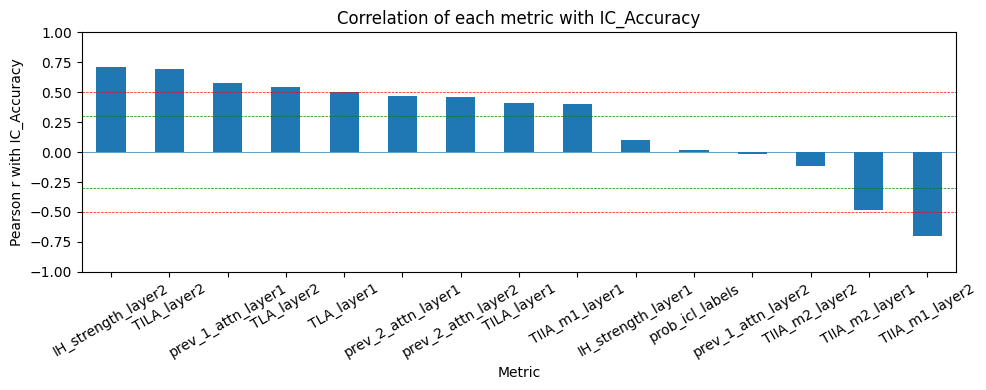

In [10]:
import matplotlib.pyplot as plt

# Assume `corr_with_ic` is a pandas Series whose index = metric names
# and whose values = Pearson r against IC_Accuracy.

fig, ax = plt.subplots(figsize=(10, 4))

corr_with_ic[2:].plot(kind="bar", ax=ax)

ax.set_xlabel("Metric")
ax.set_ylabel("Pearson r with IC_Accuracy")
ax.set_title("Correlation of each metric with IC_Accuracy")
ax.set_ylim(-1, 1)               # full Pearson range
ax.axhline(0, linewidth=0.5)     # horizontal zero line for reference
ax.axhline(0.3, linewidth=0.5, color="green", linestyle="--") # threshold for significance
ax.axhline(-0.3, linewidth=0.5, color="green", linestyle="--") # threshold for significance
ax.axhline(0.5, linewidth=0.5, color="red", linestyle="--") # threshold for significance
ax.axhline(-0.5, linewidth=0.5, color="red", linestyle="--") # threshold for significance
ax.tick_params(axis='x', labelrotation=30)
plt.tight_layout()
plt.show()


### Linear Regression

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, KFold
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
X = df.drop(columns=["IC_Accuracy", "IC2_Accuracy"])
y = df["IC_Accuracy"]     
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X
lin = LinearRegression()
cv   = KFold(n_splits=5, shuffle=True, random_state=0)
# Coefficient of determination (R²) averaged across folds
r2_lin = cross_val_score(lin, X_scaled, y, cv=cv, scoring="r2")
print(f"Linear R²  (mean±sd): {r2_lin.mean():.3f} ± {r2_lin.std():.3f}")
ridge = RidgeCV(cv=cv)
r2_ridge = cross_val_score(ridge, X_scaled, y, cv=cv, scoring="r2")
print(f"Ridge R²  (mean±sd): {r2_ridge.mean():.3f} ± {r2_ridge.std():.3f}")
lasso = LassoCV(cv=cv, random_state=0, max_iter=10000)
r2_lasso = cross_val_score(lasso, X_scaled, y, cv=cv, scoring="r2")
print(f"Lasso R²  (mean±sd): {r2_lasso.mean():.3f} ± {r2_lasso.std():.3f}")

Linear R²  (mean±sd): 0.809 ± 0.018
Ridge R²  (mean±sd): 0.809 ± 0.018
Lasso R²  (mean±sd): 0.809 ± 0.018


In [3]:
lin.fit(X_scaled, y)
coefs = lin.coef_
feature_names = X.columns

import pandas as pd
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
}).sort_values("coefficient", ascending=False)

print(coef_df)

               feature  coefficient
1   IH_strength_layer2     1.101445
6          TILA_layer1     0.286809
14     prob_icl_labels     0.121611
10  prev_1_attn_layer1     0.052647
11  prev_1_attn_layer2     0.044600
5       TIIA_m2_layer2     0.025582
2       TIIA_m1_layer1     0.016138
8           TLA_layer1    -0.115973
9           TLA_layer2    -0.168067
0   IH_strength_layer1    -0.192890
12  prev_2_attn_layer1    -0.248742
4       TIIA_m2_layer1    -0.364718
7          TILA_layer2    -0.510509
13  prev_2_attn_layer2    -0.605387
3       TIIA_m1_layer2    -0.877481


### Random Forest

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd

X = df.drop(columns=["IC_Accuracy", "IC2_Accuracy"])
y = df["IC_Accuracy"]   
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cv   = KFold(n_splits=5, shuffle=True, random_state=0)
rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        n_jobs=-1,
        random_state=0)

r2_rf = cross_val_score(rf, X_scaled, y, cv=cv, scoring="r2")
print(f"RF R²      (mean±sd): {r2_rf.mean():.3f} ± {r2_rf.std():.3f}")

# Interpreting the model
rf.fit(X_scaled, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print(feature_importances)

RF R²      (mean±sd): 0.974 ± 0.005
               Feature  Importance
1   IH_strength_layer2    0.699331
14     prob_icl_labels    0.073878
8           TLA_layer1    0.044962
7          TILA_layer2    0.032591
10  prev_1_attn_layer1    0.030379
3       TIIA_m1_layer2    0.024107
4       TIIA_m2_layer1    0.015847
5       TIIA_m2_layer2    0.015499
11  prev_1_attn_layer2    0.015352
6          TILA_layer1    0.010711
0   IH_strength_layer1    0.009262
13  prev_2_attn_layer2    0.008847
12  prev_2_attn_layer1    0.007387
2       TIIA_m1_layer1    0.007387
9           TLA_layer2    0.004459


### Linear classification

In [5]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report

# ── 0.  DATA --------------------------------------------------------------------
# df should already contain your metric columns + IC_Accuracy in the current session
y = (df["IC_Accuracy"] > 0.9).astype(int)                       # 1 = IC, 0 = not-IC
X = df.drop(columns=["IC_Accuracy", "IC2_Accuracy"])            # remove targets / near-dupe

# ── 1.  PIPELINE ----------------------------------------------------------------
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, penalty="l2",
                       class_weight="balanced",           # handles class imbalance
                       random_state=0)
)

# ── 2.  5-fold STRATIFIED CROSS-VALIDATION ACCURACY -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
print(f"5-fold accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

# ── 3.  HOLD-OUT REPORT ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("\nConfusion matrix on 20 % hold-out:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# ── 4.  FEATURE IMPORTANCE (linear weights) -------------------------------------
coef = pipe.named_steps["logisticregression"].coef_[0]          # already std-scaled
coef_rank = (pd.Series(coef, index=X.columns)
             .abs()
             .sort_values(ascending=False)
             .rename("abs_coef"))

print("\n=== Ranking by |standardised coefficient| ===")
print(coef_rank.to_frame())

# ── 5.  FEATURE IMPORTANCE (permutation) ----------------------------------------
perm = permutation_importance(
        pipe, X_test, y_test, n_repeats=40, random_state=0, scoring="accuracy")
perm_rank = (pd.Series(perm.importances_mean, index=X.columns)
             .sort_values(ascending=False)
             .rename("perm_importance"))

print("\n=== Ranking by permutation importance (Δ accuracy) ===")
print(perm_rank.to_frame())

# ── 6.  COMBINED VIEW -----------------------------------------------------------
combined = pd.concat([coef_rank, perm_rank], axis=1)
print("\n=== Side-by-side view ===")
print(combined)



5-fold accuracy: 0.920 ± 0.005

Confusion matrix on 20 % hold-out:
[[1045  117]
 [   0   38]]

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.899     0.947      1162
           1      0.245     1.000     0.394        38

    accuracy                          0.902      1200
   macro avg      0.623     0.950     0.670      1200
weighted avg      0.976     0.902     0.929      1200


=== Ranking by |standardised coefficient| ===
                    abs_coef
IH_strength_layer2  4.362862
prob_icl_labels     2.937174
prev_2_attn_layer1  2.210431
TILA_layer1         2.034211
prev_2_attn_layer2  2.018739
TIIA_m2_layer1      1.848173
TLA_layer2          1.251408
TILA_layer2         1.191246
TLA_layer1          1.152466
TIIA_m1_layer1      1.116143
prev_1_attn_layer1  1.110990
TIIA_m2_layer2      0.985108
IH_strength_layer1  0.593291
prev_1_attn_layer2  0.544831
TIIA_m1_layer2      0.377231

=== Ranking by permutation importance (Δ ac

### RF Classification

In [6]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report

# ── 0. DATA --------------------------------------------------------------------
y = (df["IC_Accuracy"] > 0.9).astype(int)                # 1 = IC, 0 = not-IC
X = df.drop(columns=["IC_Accuracy", "IC2_Accuracy"])     # avoid leakage

# ── 1. MODEL -------------------------------------------------------------------
rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,                    # let trees grow fully
        min_samples_leaf=2,                # light regularisation
        class_weight="balanced",           # handle any imbalance
        n_jobs=-1,                         # all CPU cores
        random_state=0
)

# ── 2. 5-fold STRATIFIED CV ACCURACY ------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_acc = cross_val_score(rf, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

print(f"Random-Forest 5-fold accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

# ── 3. HOLD-OUT REPORT ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\nConfusion matrix on 20 % hold-out:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# ── 4. FEATURE IMPORTANCE: built-in MDI ----------------------------------------
mdi = (pd.Series(rf.feature_importances_, index=X.columns)
       .sort_values(ascending=False)
       .rename("MDI_importance"))

print("\n=== Ranking by Random-Forest MDI importance ===")
print(mdi.to_frame())

# ── 5. FEATURE IMPORTANCE: permutation ----------------------------------------
perm = permutation_importance(
        rf, X_test, y_test, n_repeats=30, random_state=0, scoring="accuracy", n_jobs=-1)
perm_rank = (pd.Series(perm.importances_mean, index=X.columns)
             .sort_values(ascending=False)
             .rename("perm_importance"))

print("\n=== Ranking by permutation importance (Δ accuracy) ===")
print(perm_rank.to_frame())

# ── 6. COMBINED VIEW -----------------------------------------------------------
combined = pd.concat([mdi, perm_rank], axis=1)
print("\n=== Side-by-side importance table ===")
print(combined)


Random-Forest 5-fold accuracy: 0.987 ± 0.002

Confusion matrix on 20 % hold-out:
[[1153    9]
 [   7   31]]

Classification report:
              precision    recall  f1-score   support

           0      0.994     0.992     0.993      1162
           1      0.775     0.816     0.795        38

    accuracy                          0.987      1200
   macro avg      0.884     0.904     0.894      1200
weighted avg      0.987     0.987     0.987      1200


=== Ranking by Random-Forest MDI importance ===
                    MDI_importance
prob_icl_labels           0.233187
TLA_layer1                0.111480
TILA_layer1               0.089455
prev_1_attn_layer1        0.073992
IH_strength_layer2        0.068458
TIIA_m1_layer1            0.066462
prev_1_attn_layer2        0.062495
TILA_layer2               0.055696
TIIA_m2_layer1            0.046090
TIIA_m2_layer2            0.037573
prev_2_attn_layer1        0.031850
TIIA_m1_layer2            0.031693
TLA_layer2                0.031259
pr

## ICL

In [11]:

import pandas as pd
import wandb
import numpy as np

api = wandb.Api()

runs = api.runs(
    path="explainableml/ICL_torch",
    filters={
        "config.normalize_progress_measure": True,
        "config.K1": 8192,
        "config.rope": True,
    }
)
# Extract data and filter based on IC_Accuracy
runs = [
    run for run in runs 
    if run.config.get("K2", 0) in [128,256,512,1024]]
runs = [
    run for run in runs 
    if run.summary.get("IC_Accuracy", 0) > 0.9]
# ---- 1. Gather every time-step from every run ---------------------------------
#    For each metric build ONE long Series by concatenating the histories
bags = {
    "IC_Accuracy":        [],
    "IC2_Accuracy":       [],
    "IH_strength_layer1": [],
    "IH_strength_layer2": [],
    "TIIA_m1_layer1":     [],
    "TIIA_m1_layer2":     [],
    "TIIA_m2_layer1":     [],
    "TIIA_m2_layer2":     [],
    "TILA_layer1":        [],
    "TILA_layer2":        [],
    "TLA_layer1":         [],
    "TLA_layer2":         [],
    "prev_1_attn_layer1": [],
    "prev_1_attn_layer2": [],
    "prev_2_attn_layer1": [],
    "prev_2_attn_layer2": [],
    "prob_icl_labels":    [],
}

for run in runs:
    h = run.history()                     # one DataFrame per run
    for k in bags:
        # Normalize the vector
        v = (h[k] - np.mean(h[k]).item()) / np.std(h[k]).item()
        bags[k].append(v)              # keep the whole Series (all steps)

# ---- 2. Concatenate into vectors ---------------------------------------------
vectors = {k: pd.concat(v, ignore_index=True) for k, v in bags.items()}

# ---- 3. Correlation matrix (Pearson, by default) -----------------------------
df = pd.DataFrame(vectors) 
corr = df.corr(method="pearson")

# ---- 4. Correlation of every metric with IC_Accuracy -------------------------
corr_with_ic = corr["IC_Accuracy"].sort_values(ascending=False)
corr_with_ic2 = corr["IC2_Accuracy"].sort_values(ascending=False)
print(len(runs))
print("\nPearson r between each metric vector and IC_Accuracy:")
print(corr_with_ic)




5

Pearson r between each metric vector and IC_Accuracy:
IC_Accuracy           1.000000
IC2_Accuracy          0.988011
IH_strength_layer2    0.802441
TILA_layer2           0.766765
prev_1_attn_layer1    0.672629
TLA_layer1            0.657640
TLA_layer2            0.656885
TILA_layer1           0.631823
prev_2_attn_layer1    0.584356
TIIA_m1_layer1        0.550742
prev_2_attn_layer2    0.433797
IH_strength_layer1    0.210639
TIIA_m2_layer2        0.000355
prob_icl_labels      -0.013022
prev_1_attn_layer2   -0.487533
TIIA_m2_layer1       -0.588235
TIIA_m1_layer2       -0.841490
Name: IC_Accuracy, dtype: float64
